In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dna-sequence-prediction/validation.csv
/kaggle/input/dna-sequence-prediction/train.csv
/kaggle/input/dna-sequence-prediction/test.csv


In [2]:
# Install required packages 
!pip install transformers torch torchvision torchaudio --quiet

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
get_linear_schedule_with_warmup
)
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("🧬 DNA Sequence Analysis and ML Pipeline")
print("=" * 50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00


2025-08-04 17:25:32.955436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754328333.324415      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754328333.429430      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🧬 DNA Sequence Analysis and ML Pipeline
PyTorch version: 2.6.0+cu124
CUDA available: True


In [3]:
# Data Loading Function
def load_and_explore_data():
    """Load and perform initial exploration of the datasets"""
    print("\n📊 Loading datasets...")
    
    # Load datasets
    train_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/train.csv')
    test_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/test.csv')
    validation_df = pd.read_csv('/kaggle/input/dna-sequence-prediction/validation.csv')
    
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    print(f"Validation shape: {validation_df.shape}")
    
    # Display basic info
    print("\n📋 Dataset Overview:")
    print("Columns:", train_df.columns.tolist())
    print(train_df.head())
    
    # Check for missing values
    print("\n🔍 Missing Values:")
    print(train_df.isnull().sum())
    
    return train_df, test_df, validation_df

# Load the data
train_df, test_df, validation_df = load_and_explore_data()


📊 Loading datasets...
Train shape: (22593, 7)
Test shape: (8326, 7)
Validation shape: (4577, 7)

📋 Dataset Overview:
Columns: ['Unnamed: 0', 'NCBIGeneID', 'Symbol', 'Description', 'GeneType', 'GeneGroupMethod', 'NucleotideSequence']
   Unnamed: 0  NCBIGeneID        Symbol  \
0           0   106481178      RNU4-21P   
1           1   123477792  LOC123477792   
2           2   113174975  LOC113174975   
3           3   116216107  LOC116216107   
4           4       28502      IGHD2-21   

                                         Description           GeneType  \
0               RNA, U4 small nuclear 21, pseudogene             PSEUDO   
1                Sharpr-MPRA regulatory region 12926  BIOLOGICAL_REGION   
2                 Sharpr-MPRA regulatory region 7591  BIOLOGICAL_REGION   
3  CRISPRi-validated cis-regulatory element chr10...  BIOLOGICAL_REGION   
4                immunoglobulin heavy diversity 2-21              OTHER   

  GeneGroupMethod                                 Nucleo

In [4]:
# Exploratory Data Analysis Function
def exploratory_data_analysis(train_df):
    """Perform comprehensive EDA"""
    print("\n🔬 Exploratory Data Analysis")
    print("-" * 30)
    
    # Analyze gene types
    plt.figure(figsize=(15, 10))
    
    # Gene type distribution
    plt.subplot(2, 3, 1)
    gene_type_counts = train_df['GeneType'].value_counts()
    plt.pie(gene_type_counts.values, labels=gene_type_counts.index, autopct='%1.1f%%')
    plt.title('Gene Type Distribution')
    
    # Sequence length distribution
    plt.subplot(2, 3, 2)
    train_df['seq_length'] = train_df['NucleotideSequence'].str.len()
    plt.hist(train_df['seq_length'], bins=50, edgecolor='black', alpha=0.7)
    plt.title('Sequence Length Distribution')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    
    # Gene group method distribution
    plt.subplot(2, 3, 3)
    method_counts = train_df['GeneGroupMethod'].value_counts()
    plt.bar(range(len(method_counts)), method_counts.values)
    plt.title('Gene Group Method Distribution')
    plt.xticks(range(len(method_counts)), method_counts.index, rotation=45)
    
    # Nucleotide composition analysis
    plt.subplot(2, 3, 4)
    def analyze_nucleotide_composition(sequences):
        composition = {'A': 0, 'T': 0, 'G': 0, 'C': 0, 'N': 0}
        total_length = 0
        
        for seq in sequences:
            if pd.notna(seq):
                seq = seq.upper()
                total_length += len(seq)
                for nucleotide in composition.keys():
                    composition[nucleotide] += seq.count(nucleotide)
        
        # Convert to percentages
        for nucleotide in composition:
            composition[nucleotide] = (composition[nucleotide] / total_length) * 100
            
        return composition
    
    composition = analyze_nucleotide_composition(train_df['NucleotideSequence'])
    plt.bar(composition.keys(), composition.values())
    plt.title('Nucleotide Composition (%)')
    plt.ylabel('Percentage')
    
    # Sequence length by gene type
    plt.subplot(2, 3, 5)
    sns.boxplot(data=train_df, x='GeneType', y='seq_length')
    plt.title('Sequence Length by Gene Type')
    plt.xticks(rotation=45)
    
    # Gene type vs sequence length scatter
    plt.subplot(2, 3, 6)
    for gene_type in train_df['GeneType'].unique():
        subset = train_df[train_df['GeneType'] == gene_type]
        plt.scatter(subset['seq_length'], [gene_type] * len(subset), alpha=0.6, label=gene_type)
    plt.xlabel('Sequence Length')
    plt.ylabel('Gene Type')
    plt.title('Gene Type vs Sequence Length')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\n📊 Statistical Summary:")
    print(f"Average sequence length: {train_df['seq_length'].mean():.2f}")
    print(f"Median sequence length: {train_df['seq_length'].median():.2f}")
    print(f"Max sequence length: {train_df['seq_length'].max()}")
    print(f"Min sequence length: {train_df['seq_length'].min()}")
    
    return train_df


🔬 Exploratory Data Analysis
------------------------------


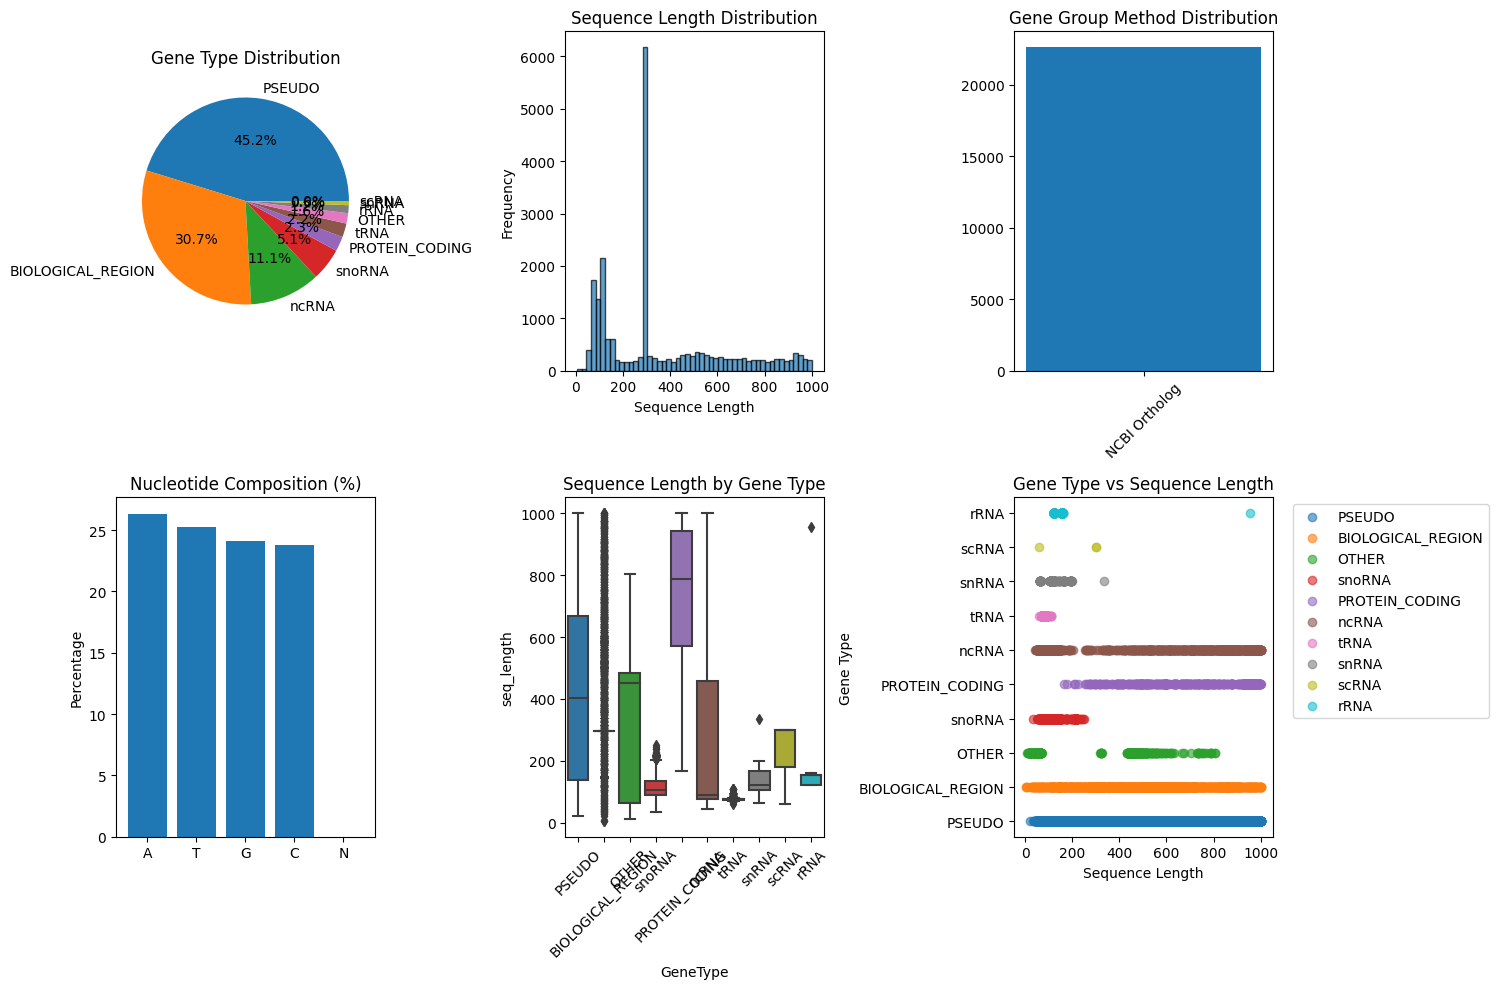


📊 Statistical Summary:
Average sequence length: 361.72
Median sequence length: 297.00
Max sequence length: 1002
Min sequence length: 4


In [5]:
# Perform exploratory data analysis
train_df = exploratory_data_analysis(train_df)

In [6]:
# Data Preprocessing Functions
def preprocess_sequences(df, max_length=512):
    """Preprocess DNA sequences for BERT input"""
    print(f"\n🔧 Preprocessing sequences (max_length={max_length})...")
    
    # Clean sequences
    df = df.copy()
    df['NucleotideSequence'] = df['NucleotideSequence'].fillna('')
    df['NucleotideSequence'] = df['NucleotideSequence'].str.upper()
    
    # Remove invalid characters and keep only ATGCN
    df['NucleotideSequence'] = df['NucleotideSequence'].str.replace(r'[^ATGCN]', '', regex=True)
    
    # Truncate sequences that are too long
    df['NucleotideSequence'] = df['NucleotideSequence'].str[:max_length-2]  # Reserve space for special tokens
    
    # Add spaces between nucleotides for tokenization
    df['processed_sequence'] = df['NucleotideSequence'].apply(lambda x: ' '.join(list(x)) if x else '')
    
    print(f"Processed {len(df)} sequences")
    print(f"Average processed length: {df['processed_sequence'].str.len().mean():.2f}")
    
    return df

def prepare_labels(train_df, validation_df):
    """Prepare and encode labels"""
    print("\n🏷️ Preparing labels...")
    
    # Use GeneType as target variable
    label_encoder = LabelEncoder()
    
    # Fit on all unique labels from train and validation
    all_labels = pd.concat([train_df['GeneType'], validation_df['GeneType']]).unique()
    label_encoder.fit(all_labels)
    
    train_df['labels'] = label_encoder.transform(train_df['GeneType'])
    validation_df['labels'] = label_encoder.transform(validation_df['GeneType'])
    
    print(f"Number of unique labels: {len(label_encoder.classes_)}")
    print("Label mapping:", dict(enumerate(label_encoder.classes_)))
    
    return train_df, validation_df, label_encoder

In [7]:
# Set maximum sequence length
max_seq_length = 512  # Adjust based on your data and memory constraints

# Preprocess all datasets
train_df = preprocess_sequences(train_df, max_seq_length)
validation_df = preprocess_sequences(validation_df, max_seq_length)
test_df = preprocess_sequences(test_df, max_seq_length)

# Prepare labels
train_df, validation_df, label_encoder = prepare_labels(train_df, validation_df)


🔧 Preprocessing sequences (max_length=512)...
Processed 22593 sequences
Average processed length: 598.21

🔧 Preprocessing sequences (max_length=512)...
Processed 4577 sequences
Average processed length: 603.37

🔧 Preprocessing sequences (max_length=512)...
Processed 8326 sequences
Average processed length: 604.76

🏷️ Preparing labels...
Number of unique labels: 10
Label mapping: {0: 'BIOLOGICAL_REGION', 1: 'OTHER', 2: 'PROTEIN_CODING', 3: 'PSEUDO', 4: 'ncRNA', 5: 'rRNA', 6: 'scRNA', 7: 'snRNA', 8: 'snoRNA', 9: 'tRNA'}


In [8]:
#  Custom Dataset Class
class DNASequenceDataset(Dataset):
    """Custom dataset for DNA sequences"""
    
    def __init__(self, sequences, labels, tokenizer, max_length=512):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = str(self.sequences.iloc[idx])
        label = self.labels.iloc[idx]
        
        # Tokenize sequence
        encoding = self.tokenizer(
            sequence,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✅ Dataset class defined successfully!")

✅ Dataset class defined successfully!


In [9]:
def create_data_loaders(train_df, val_df, tokenizer, batch_size=16, max_length=512):
    """Create data loaders for training and validation"""
    print(f"\n📦 Creating data loaders (batch_size={batch_size})...")
    
    train_dataset = DNASequenceDataset(
        train_df['processed_sequence'],
        train_df['labels'],
        tokenizer,
        max_length
    )
    
    val_dataset = DNASequenceDataset(
        val_df['processed_sequence'],
        val_df['labels'],
        tokenizer,
        max_length
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    return train_loader, val_loader

print("✅ Data loader function defined!")

✅ Data loader function defined!


In [10]:
# Initialize tokenizer and model
print("\n🤖 Initializing DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

print(f"Model initialized with {len(label_encoder.classes_)} output classes")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


🤖 Initializing DistilBERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 10 output classes
Model parameters: 66,961,162


In [11]:
# Create Data Loaders
batch_size = 16  # Adjust based on GPU memory
train_loader, val_loader = create_data_loaders(
    train_df, validation_df, tokenizer, batch_size=batch_size, max_length=max_seq_length
)


📦 Creating data loaders (batch_size=16)...
Train batches: 1413
Validation batches: 287


In [12]:
# Training Functions
def evaluate_model(model, data_loader, device):
    """Evaluate model performance"""
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

def train_model(model, train_loader, val_loader, num_epochs=3, learning_rate=2e-5):
    """Train the DistilBERT model"""
    print(f"\n🚀 Training model for {num_epochs} epochs...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)
        
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        val_accuracy = evaluate_model(model, val_loader, device)
        val_accuracies.append(val_accuracy)
        
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}")
    
    return model, train_losses, val_accuracies

print("✅ Training functions defined!")

✅ Training functions defined!


In [13]:
# Train the model
num_epochs = 2  
learning_rate = 2e-5

trained_model, train_losses, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate
)


🚀 Training model for 2 epochs...

Epoch 1/2
--------------------
Batch 0/1413, Loss: 2.2865
Batch 100/1413, Loss: 1.2848
Batch 200/1413, Loss: 0.2475
Batch 300/1413, Loss: 0.7708
Batch 400/1413, Loss: 0.7695
Batch 500/1413, Loss: 0.4232
Batch 600/1413, Loss: 0.6240
Batch 700/1413, Loss: 0.7891
Batch 800/1413, Loss: 1.0239
Batch 900/1413, Loss: 0.8506
Batch 1000/1413, Loss: 0.8105
Batch 1100/1413, Loss: 0.6411
Batch 1200/1413, Loss: 0.5789
Batch 1300/1413, Loss: 0.9375
Batch 1400/1413, Loss: 0.6936
Average training loss: 0.7864
Validation accuracy: 0.8042

Epoch 2/2
--------------------
Batch 0/1413, Loss: 0.4715
Batch 100/1413, Loss: 1.0287
Batch 200/1413, Loss: 0.8555
Batch 300/1413, Loss: 0.9617
Batch 400/1413, Loss: 0.6131
Batch 500/1413, Loss: 0.4055
Batch 600/1413, Loss: 0.2376
Batch 700/1413, Loss: 0.5737
Batch 800/1413, Loss: 0.7325
Batch 900/1413, Loss: 0.2186
Batch 1000/1413, Loss: 0.6431
Batch 1100/1413, Loss: 0.3063
Batch 1200/1413, Loss: 0.2646
Batch 1300/1413, Loss: 0.744

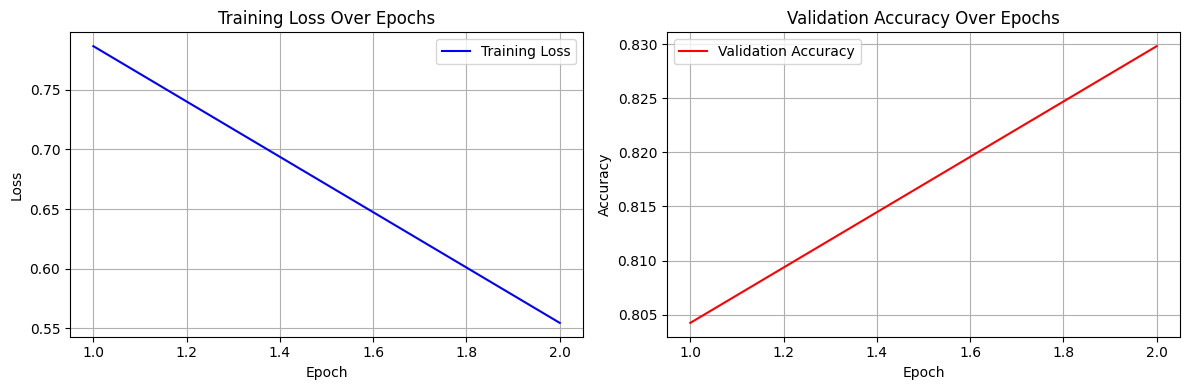


🎯 Final Training Loss: 0.5547
🎯 Final Validation Accuracy: 0.8298


In [14]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Display final metrics
print(f"\n🎯 Final Training Loss: {train_losses[-1]:.4f}")
print(f"🎯 Final Validation Accuracy: {val_accuracies[-1]:.4f}")

In [15]:
# Make predictions on test set
if 'GeneType' not in test_df.columns:
    print("\n🔮 Making predictions on test set...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    test_dataset = DNASequenceDataset(
        test_df['processed_sequence'],
        pd.Series([0] * len(test_df)),  # Dummy labels
        tokenizer,
        max_seq_length
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    trained_model.eval()
    test_predictions = []
    prediction_probabilities = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = trained_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            
            test_predictions.extend(predictions)
            prediction_probabilities.extend(probabilities.cpu().numpy())
    
    # Convert predictions back to labels
    test_predictions_labels = label_encoder.inverse_transform(test_predictions)
    test_df['predicted_gene_type'] = test_predictions_labels
    
    # Add confidence scores
    test_df['prediction_confidence'] = [max(prob) for prob in prediction_probabilities]
    
    print("✅ Test predictions completed!")
    print("\nSample predictions:")
    print(test_df[['Symbol', 'predicted_gene_type', 'prediction_confidence']].head(10))

In [16]:
def save_model_and_artifacts(model, tokenizer, label_encoder, save_path='./dna_model'):
    """Save trained model and preprocessing artifacts"""
    import os
    os.makedirs(save_path, exist_ok=True)
    
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    
    import pickle
    with open(f'{save_path}/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print(f"✅ Model saved to {save_path}")

# Save the trained model
save_model_and_artifacts(trained_model, tokenizer, label_encoder)

# Save predictions to CSV
if 'predicted_gene_type' in test_df.columns:
    submission_df = test_df[['Symbol', 'predicted_gene_type', 'prediction_confidence']].copy()
    submission_df.to_csv('dna_predictions.csv', index=False)
    print("✅ Predictions saved to dna_predictions.csv")

✅ Model saved to ./dna_model


In [17]:
def predict_single_sequence(sequence, model, tokenizer, label_encoder, max_length=512):
    """Predict gene type for a single DNA sequence"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Preprocess sequence
    sequence = sequence.upper().replace(r'[^ATGCN]', '')[:max_length-2]
    processed_sequence = ' '.join(list(sequence))
    
    # Tokenize
    encoding = tokenizer(
        processed_sequence,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Predict
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
        confidence = torch.softmax(outputs.logits, dim=1).max().item()
    
    predicted_label = label_encoder.inverse_transform([prediction])[0]
    
    return predicted_label, confidence

# Example usage
sample_sequence = "ATCGATCGATCGATCG"  # Replace with actual sequence
if len(sample_sequence) > 0:
    pred_label, confidence = predict_single_sequence(
        sample_sequence, trained_model, tokenizer, label_encoder
    )
    print(f"\n🧪 Sample Prediction:")
    print(f"Sequence: {sample_sequence}")
    print(f"Predicted Gene Type: {pred_label}")
    print(f"Confidence: {confidence:.4f}")


🧪 Sample Prediction:
Sequence: ATCGATCGATCGATCG
Predicted Gene Type: OTHER
Confidence: 0.2001


In [18]:
print("\n" + "="*60)
print("🎉 DNA SEQUENCE ANALYSIS PIPELINE COMPLETED!")
print("="*60)
print(f"📊 Total training samples: {len(train_df):,}")
print(f"📊 Total validation samples: {len(validation_df):,}")
print(f"📊 Total test samples: {len(test_df):,}")
print(f"🏷️ Number of gene types: {len(label_encoder.classes_)}")
print(f"🎯 Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"💾 Model saved successfully")
print(f"📁 Predictions saved to CSV")



🎉 DNA SEQUENCE ANALYSIS PIPELINE COMPLETED!
📊 Total training samples: 22,593
📊 Total validation samples: 4,577
📊 Total test samples: 8,326
🏷️ Number of gene types: 10
🎯 Final validation accuracy: 0.8298
💾 Model saved successfully
📁 Predictions saved to CSV
